# ALPOD Lake Preprocessing for Ice Phenology Analysis
## Part 1: Load, Filter, and Calculate Metrics

**Goal:** Prep ALPOD lakes for multi-year ice detection

**Steps:**
1. Load ALPOD shapefile from GCS bucket
2. Filter to North Slope thermokarst region (lat >= 69°N)
3. Reproject to Alaska Albers Equal Area (EPSG:3338)
4. Recalculate lake morphometry metrics in this projection
5. Filter to lakes > 0.05 km² (reliable for S1/S2 detection)
6. Create spatial chunks (~1,500 lakes each)
7. Save processed chunks to bucket for GEE processing

**Output:** Spatially chunked lake datasets ready for 2019-2021 ice phenology analysis

---
## Setup

In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Point
from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings('ignore')

print("Imports successful!")

Imports successful!


In [2]:
# Configuration
BUCKET = 'wustl-eeps-geospatial'
BASE_PATH = 'thermokarst_lakes'
ALPOD_PATH = f'gs://{BUCKET}/{BASE_PATH}/ALPODlakes/ALPODlakes.shp'
OUTPUT_PATH = f'gs://{BUCKET}/{BASE_PATH}/processed'

# Filtering parameters
MIN_LAT = 69.0  # North Slope thermokarst region
MIN_AREA_KM2 = 0.05  # Minimum area for reliable S1/S2 detection
TARGET_LAKES_PER_CHUNK = 1500  # Target chunk size

# Projections
WGS84 = 'EPSG:4326'
ALASKA_ALBERS = 'EPSG:3338'  # Alaska Albers Equal Area

print(f"Configuration:")
print(f"  Input: {ALPOD_PATH}")
print(f"  Output: {OUTPUT_PATH}")
print(f"  Filter: lat >= {MIN_LAT}°N, area >= {MIN_AREA_KM2} km²")
print(f"  Target chunk size: {TARGET_LAKES_PER_CHUNK} lakes")

Configuration:
  Input: gs://wustl-eeps-geospatial/thermokarst_lakes/ALPODlakes/ALPODlakes.shp
  Output: gs://wustl-eeps-geospatial/thermokarst_lakes/processed
  Filter: lat >= 69.0°N, area >= 0.05 km²
  Target chunk size: 1500 lakes


---
## Step 1: Load ALPOD Shapefile

In [4]:
# Fix PROJ database path if needed
import os
# Try to locate the correct PROJ data directory
try:
    import pyproj
    proj_data_dir = pyproj.datadir.get_data_dir()
    os.environ['PROJ_LIB'] = proj_data_dir
    print(f"Set PROJ_LIB to: {proj_data_dir}")
except Exception as e:
    print(f"Could not auto-detect PROJ data dir: {e}")
    print("Attempting to load shapefile anyway...")

# Load ALPOD shapefile from bucket
print("\nLoading ALPOD shapefile from bucket...")
lakes = gpd.read_file(ALPOD_PATH)

print(f"\nLoaded {len(lakes):,} lakes from ALPOD")
print(f"CRS: {lakes.crs}")
print(f"\nColumns: {lakes.columns.tolist()}")
print(f"\nFirst few rows:")
print(lakes.head())

Set PROJ_LIB to: /opt/conda/envs/gee/share/proj

Loading ALPOD shapefile from bucket...

Loaded 801,895 lakes from ALPOD
CRS: EPSG:3338

Columns: ['area', 'perimeter', 'id', 'geometry']

First few rows:
            area    perimeter  id  \
0  162419.231964  2437.168920   1   
1   27319.239899  1081.763907   2   
2   69230.709167  1664.266024   3   
3    5670.033508   384.649795   4   
4    4314.689270   321.756222   5   

                                            geometry  
0  POLYGON ((180860.756 2064396.126, 180861.41 20...  
1  POLYGON ((178711.35 2085654.803, 178712.001 20...  
2  POLYGON ((178664.804 2086307.966, 178665.455 2...  
3  POLYGON ((178583.858 2086977.788, 178583.828 2...  
4  POLYGON ((178550.017 2087492.664, 178550.667 2...  


In [5]:
# Check data types and basic stats
print("ALPOD attributes:")
print(lakes.dtypes)
print(f"\nGeometry type: {lakes.geometry.type.unique()}")
print(f"Bounds: {lakes.total_bounds}")

ALPOD attributes:
area          float64
perimeter     float64
id              int64
geometry     geometry
dtype: object

Geometry type: ['Polygon' 'MultiPolygon' None]
Bounds: [-1674816.70993491   417614.7985957   1491950.71746127  2375493.39808125]


---
## Step 2: Initial Filtering - Geographic Region

In [6]:
# Calculate centroids to filter by latitude
# Do this in WGS84 before reprojection
if lakes.crs != WGS84:
    lakes_wgs84 = lakes.to_crs(WGS84)
else:
    lakes_wgs84 = lakes.copy()

# Get centroid latitude
lakes_wgs84['centroid_lat'] = lakes_wgs84.geometry.centroid.y
lakes_wgs84['centroid_lon'] = lakes_wgs84.geometry.centroid.x

# Filter to North Slope (thermokarst region)
lakes_northslope = lakes_wgs84[lakes_wgs84['centroid_lat'] >= MIN_LAT].copy()

print(f"Filtering to North Slope (lat >= {MIN_LAT}°N):")
print(f"  Original: {len(lakes):,} lakes")
print(f"  Filtered: {len(lakes_northslope):,} lakes")
print(f"  Removed: {len(lakes) - len(lakes_northslope):,} lakes")

print(f"\nLatitude range: {lakes_northslope['centroid_lat'].min():.2f}°N to {lakes_northslope['centroid_lat'].max():.2f}°N")
print(f"Longitude range: {lakes_northslope['centroid_lon'].min():.2f}° to {lakes_northslope['centroid_lon'].max():.2f}°")

Filtering to North Slope (lat >= 69.0°N):
  Original: 801,895 lakes
  Filtered: 128,197 lakes
  Removed: 673,698 lakes

Latitude range: 69.00°N to 71.36°N
Longitude range: -163.85° to -141.02°


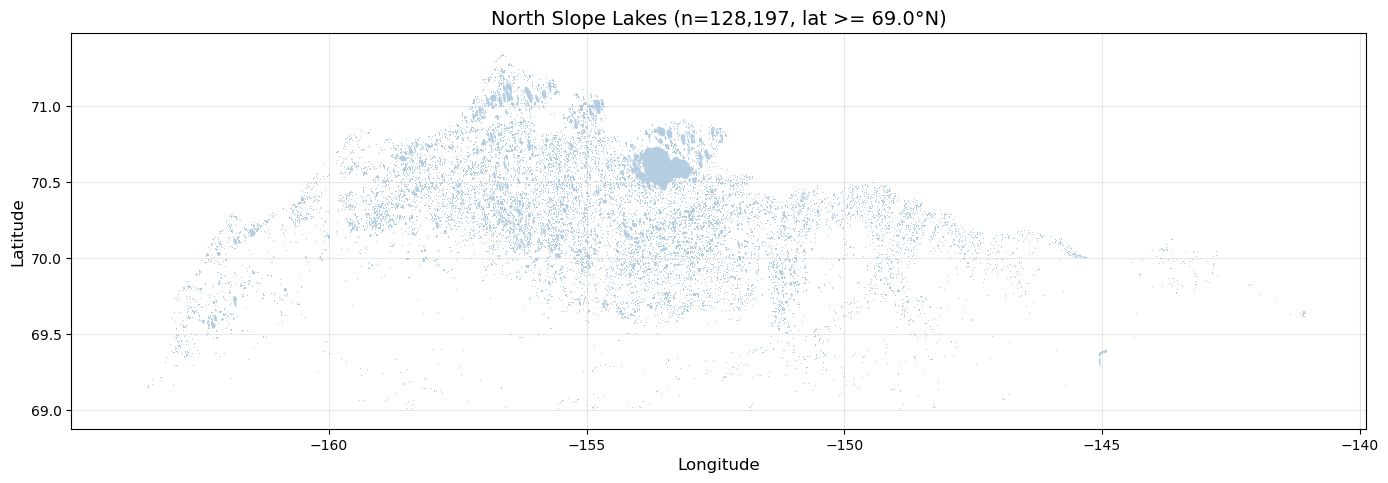

Saved: north_slope_lakes_distribution.png


In [7]:
# Visualize spatial distribution
fig, ax = plt.subplots(figsize=(14, 8))
lakes_northslope.plot(ax=ax, markersize=0.5, alpha=0.4, color='steelblue')
ax.set_xlabel('Longitude', fontsize=12)
ax.set_ylabel('Latitude', fontsize=12)
ax.set_title(f'North Slope Lakes (n={len(lakes_northslope):,}, lat >= {MIN_LAT}°N)', fontsize=14)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('north_slope_lakes_distribution.png', dpi=150, bbox_inches='tight')
plt.show()
print("Saved: north_slope_lakes_distribution.png")

---
## Step 3: Reproject to Alaska Albers Equal Area (EPSG:3338)

In [8]:
# Reproject to Alaska Albers for accurate area/perimeter calculations
print(f"Reprojecting from {WGS84} to {ALASKA_ALBERS}...")
lakes_albers = lakes_northslope.to_crs(ALASKA_ALBERS)

print(f"Reprojection complete!")
print(f"New CRS: {lakes_albers.crs}")
print(f"Units: meters")

Reprojecting from EPSG:4326 to EPSG:3338...
Reprojection complete!
New CRS: EPSG:3338
Units: meters


---
## Step 4: Calculate Lake Morphometry Metrics

In [9]:
print("Calculating lake morphometry metrics in EPSG:3338...")

# Basic metrics
lakes_albers['lake_area_m2'] = lakes_albers.geometry.area
lakes_albers['lake_area_km2'] = lakes_albers['lake_area_m2'] / 1e6
lakes_albers['lake_perim_m'] = lakes_albers.geometry.length

# Circularity: 4π × Area / Perimeter²
# Perfect circle = 1.0, more irregular shapes < 1.0
lakes_albers['circularity'] = (
    4 * np.pi * lakes_albers['lake_area_m2'] / 
    (lakes_albers['lake_perim_m'] ** 2)
)

# Fractal dimension: 2 × ln(Perimeter/4) / ln(Area)
# Measures coastline complexity
lakes_albers['fractal_dim'] = (
    2 * np.log(lakes_albers['lake_perim_m'] / 4) / 
    np.log(lakes_albers['lake_area_m2'])
)

# Convexity: Area / ConvexHullArea
# Perfect convex shape = 1.0, irregular/concave < 1.0
convex_hulls = lakes_albers.geometry.convex_hull
convex_areas = convex_hulls.area
lakes_albers['convexity'] = lakes_albers['lake_area_m2'] / convex_areas

# Centroid coordinates in Albers projection (for spatial analysis)
centroids_albers = lakes_albers.geometry.centroid
lakes_albers['centroid_x_albers'] = centroids_albers.x
lakes_albers['centroid_y_albers'] = centroids_albers.y

print("Metrics calculated!")
print(f"\nMetrics summary:")
print(lakes_albers[['lake_area_km2', 'lake_perim_m', 'circularity', 
                     'fractal_dim', 'convexity']].describe())

Calculating lake morphometry metrics in EPSG:3338...
Metrics calculated!

Metrics summary:
       lake_area_km2   lake_perim_m    circularity    fractal_dim  \
count  128197.000000  128197.000000  128197.000000  128197.000000   
mean        0.077731     927.169579       0.405084       1.082133   
std         2.450187    2295.861868       0.137897       0.042610   
min         0.001000     133.240354       0.009952       0.996545   
25%         0.002037     241.650060       0.306000       1.049664   
50%         0.004906     401.856010       0.417145       1.072780   
75%         0.018948     855.578068       0.508458       1.107119   
max       858.993864  508919.141269       0.811365       1.328754   

           convexity  
count  128197.000000  
mean        0.801535  
std         0.105620  
min         0.111598  
25%         0.745098  
50%         0.822222  
75%         0.879656  
max         1.000000  


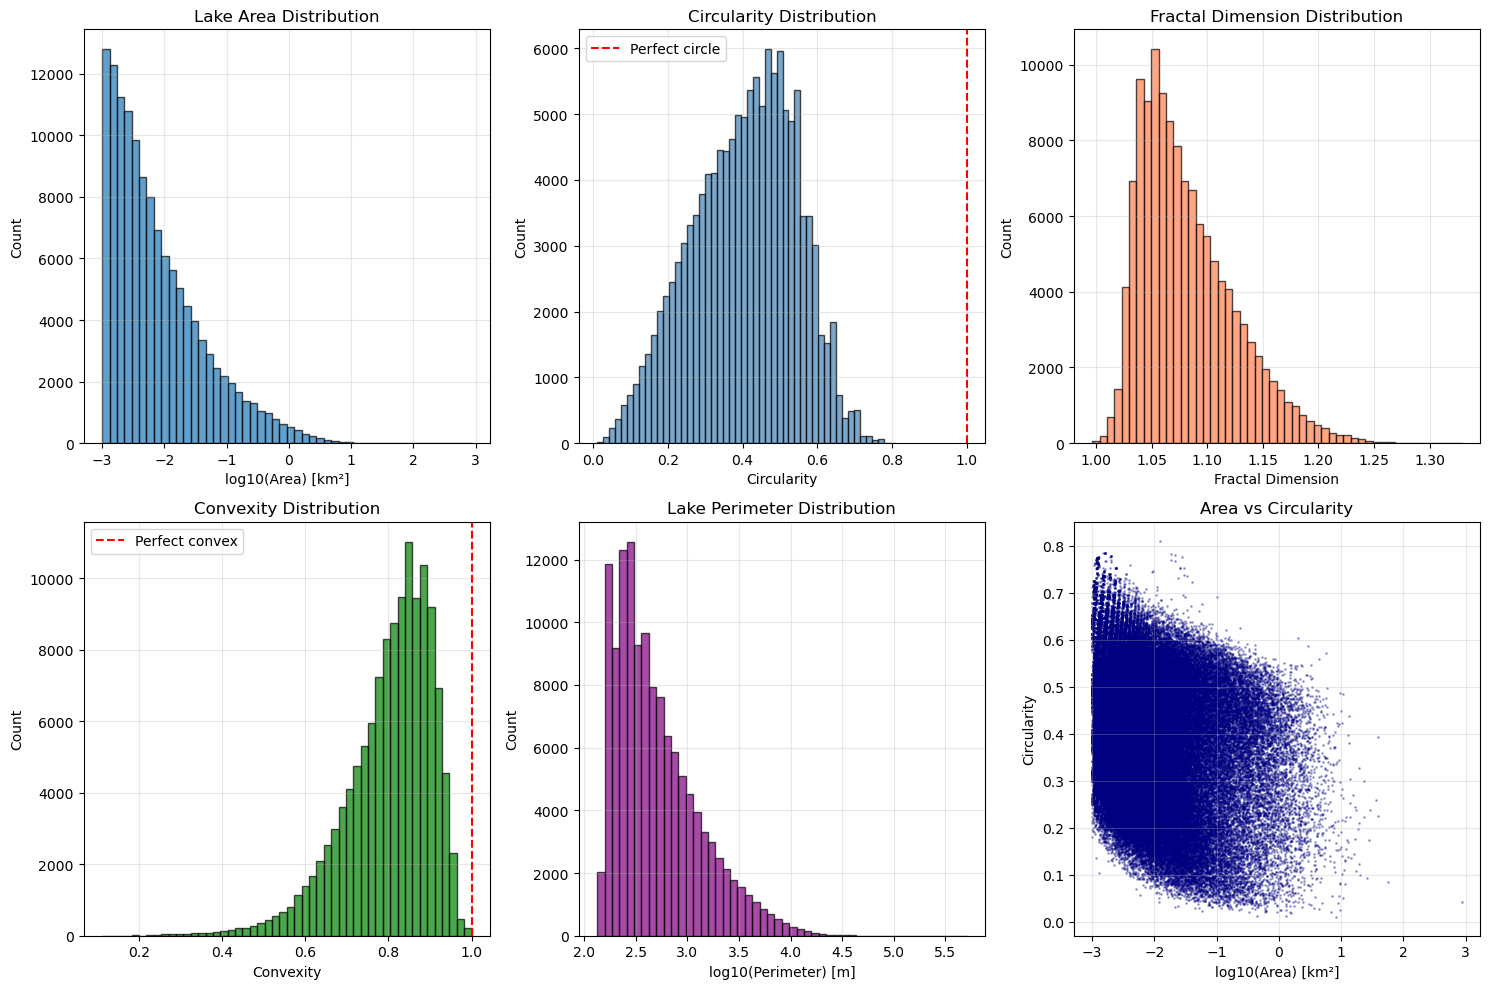

Saved: lake_metrics_distributions.png


In [10]:
# Visualize metric distributions
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Area (log scale)
axes[0, 0].hist(np.log10(lakes_albers['lake_area_km2']), bins=50, 
                edgecolor='black', alpha=0.7)
axes[0, 0].set_xlabel('log10(Area) [km²]')
axes[0, 0].set_ylabel('Count')
axes[0, 0].set_title('Lake Area Distribution')
axes[0, 0].grid(alpha=0.3)

# Circularity
axes[0, 1].hist(lakes_albers['circularity'], bins=50, 
                edgecolor='black', alpha=0.7, color='steelblue')
axes[0, 1].set_xlabel('Circularity')
axes[0, 1].set_ylabel('Count')
axes[0, 1].set_title('Circularity Distribution')
axes[0, 1].axvline(1.0, color='red', linestyle='--', label='Perfect circle')
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

# Fractal dimension
axes[0, 2].hist(lakes_albers['fractal_dim'], bins=50, 
                edgecolor='black', alpha=0.7, color='coral')
axes[0, 2].set_xlabel('Fractal Dimension')
axes[0, 2].set_ylabel('Count')
axes[0, 2].set_title('Fractal Dimension Distribution')
axes[0, 2].grid(alpha=0.3)

# Convexity
axes[1, 0].hist(lakes_albers['convexity'], bins=50, 
                edgecolor='black', alpha=0.7, color='green')
axes[1, 0].set_xlabel('Convexity')
axes[1, 0].set_ylabel('Count')
axes[1, 0].set_title('Convexity Distribution')
axes[1, 0].axvline(1.0, color='red', linestyle='--', label='Perfect convex')
axes[1, 0].legend()
axes[1, 0].grid(alpha=0.3)

# Perimeter
axes[1, 1].hist(np.log10(lakes_albers['lake_perim_m']), bins=50, 
                edgecolor='black', alpha=0.7, color='purple')
axes[1, 1].set_xlabel('log10(Perimeter) [m]')
axes[1, 1].set_ylabel('Count')
axes[1, 1].set_title('Lake Perimeter Distribution')
axes[1, 1].grid(alpha=0.3)

# Area vs Circularity scatter
axes[1, 2].scatter(np.log10(lakes_albers['lake_area_km2']), 
                   lakes_albers['circularity'], 
                   s=1, alpha=0.3, color='navy')
axes[1, 2].set_xlabel('log10(Area) [km²]')
axes[1, 2].set_ylabel('Circularity')
axes[1, 2].set_title('Area vs Circularity')
axes[1, 2].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('lake_metrics_distributions.png', dpi=150, bbox_inches='tight')
plt.show()
print("Saved: lake_metrics_distributions.png")

---
## Step 5: Filter by Size (> 0.05 km²)

In [11]:
# Filter to lakes large enough for reliable S1/S2 detection
lakes_final = lakes_albers[lakes_albers['lake_area_km2'] > MIN_AREA_KM2].copy()

print(f"Filtering by size (area > {MIN_AREA_KM2} km²):")
print(f"  Before: {len(lakes_albers):,} lakes")
print(f"  After: {len(lakes_final):,} lakes")
print(f"  Removed: {len(lakes_albers) - len(lakes_final):,} lakes")

print(f"\nFinal dataset statistics:")
print(f"  Total lakes: {len(lakes_final):,}")
print(f"  Area range: {lakes_final['lake_area_km2'].min():.4f} - {lakes_final['lake_area_km2'].max():.2f} km²")
print(f"  Median area: {lakes_final['lake_area_km2'].median():.4f} km²")
print(f"  Latitude range: {lakes_final['centroid_lat'].min():.2f}°N - {lakes_final['centroid_lat'].max():.2f}°N")

Filtering by size (area > 0.05 km²):
  Before: 128,197 lakes
  After: 18,210 lakes
  Removed: 109,987 lakes

Final dataset statistics:
  Total lakes: 18,210
  Area range: 0.0500 - 858.99 km²
  Median area: 0.1491 km²
  Latitude range: 69.00°N - 71.36°N


---
## Step 6: Create Spatial Chunks

In [12]:
def create_spatial_chunks(gdf, target_size=1500):
    """
    Create spatial chunks using K-means clustering on centroids.
    Targets approximately target_size lakes per chunk.
    """
    # Calculate number of chunks needed
    n_chunks = int(np.ceil(len(gdf) / target_size))
    
    print(f"Creating {n_chunks} spatial chunks (target: {target_size} lakes/chunk)...")
    
    # Use centroids for clustering
    coords = np.column_stack([gdf['centroid_lon'].values, 
                               gdf['centroid_lat'].values])
    
    # K-means clustering
    kmeans = KMeans(n_clusters=n_chunks, random_state=42, n_init=10)
    gdf['chunk_id'] = kmeans.fit_predict(coords)
    
    # Report chunk sizes and bounds
    print(f"\nChunk summary:")
    chunk_stats = []
    
    for chunk_id in sorted(gdf['chunk_id'].unique()):
        chunk_data = gdf[gdf['chunk_id'] == chunk_id]
        
        stats = {
            'chunk_id': chunk_id,
            'n_lakes': len(chunk_data),
            'lon_min': chunk_data['centroid_lon'].min(),
            'lon_max': chunk_data['centroid_lon'].max(),
            'lat_min': chunk_data['centroid_lat'].min(),
            'lat_max': chunk_data['centroid_lat'].max(),
            'area_min_km2': chunk_data['lake_area_km2'].min(),
            'area_max_km2': chunk_data['lake_area_km2'].max(),
            'area_median_km2': chunk_data['lake_area_km2'].median()
        }
        chunk_stats.append(stats)
        
        print(f"  Chunk {chunk_id:2d}: {stats['n_lakes']:5d} lakes | "
              f"Lon: {stats['lon_min']:7.2f} to {stats['lon_max']:7.2f} | "
              f"Lat: {stats['lat_min']:6.2f} to {stats['lat_max']:6.2f}")
    
    chunk_stats_df = pd.DataFrame(chunk_stats)
    
    return gdf, chunk_stats_df

# Create chunks
lakes_chunked, chunk_stats = create_spatial_chunks(lakes_final, 
                                                     target_size=TARGET_LAKES_PER_CHUNK)

Creating 13 spatial chunks (target: 1500 lakes/chunk)...

Chunk summary:
  Chunk  0:  2083 lakes | Lon: -153.13 to -151.73 | Lat:  69.16 to  70.90
  Chunk  1:  1452 lakes | Lon: -159.37 to -157.86 | Lat:  69.01 to  70.83
  Chunk  2:  1327 lakes | Lon: -150.35 to -148.89 | Lat:  69.04 to  70.50
  Chunk  3:  2518 lakes | Lon: -155.56 to -154.20 | Lat:  69.01 to  71.12
  Chunk  4:   780 lakes | Lon: -163.58 to -161.00 | Lat:  69.03 to  70.29
  Chunk  5:   223 lakes | Lon: -144.85 to -141.05 | Lat:  69.06 to  70.12
  Chunk  6:  1987 lakes | Lon: -157.93 to -156.62 | Lat:  69.02 to  71.33
  Chunk  7:   910 lakes | Lon: -149.01 to -147.41 | Lat:  69.00 to  70.39
  Chunk  8:  2044 lakes | Lon: -154.46 to -153.03 | Lat:  69.02 to  70.90
  Chunk  9:  1383 lakes | Lon: -151.90 to -150.24 | Lat:  69.00 to  70.48
  Chunk 10:   903 lakes | Lon: -161.14 to -159.33 | Lat:  69.02 to  70.84
  Chunk 11:  2148 lakes | Lon: -156.63 to -155.38 | Lat:  69.30 to  71.36
  Chunk 12:   452 lakes | Lon: -147.41 

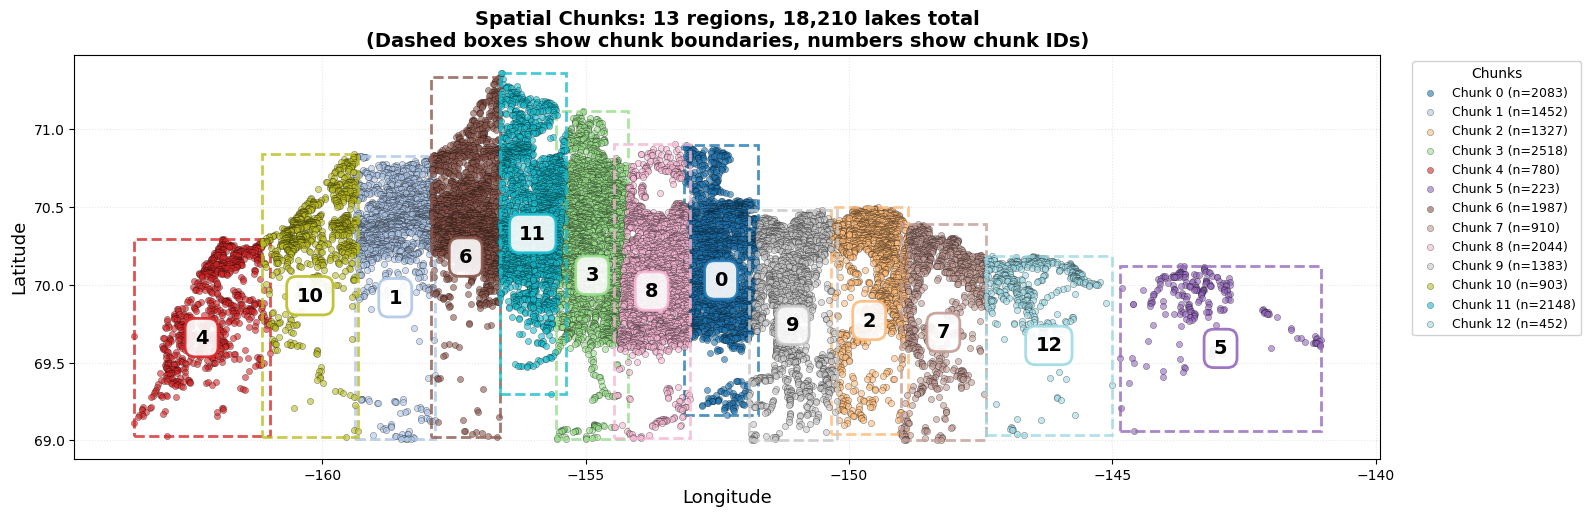

Saved: spatial_chunks.png


In [16]:
# Visualize chunks with clear boundaries
from matplotlib.patches import Rectangle
import matplotlib.cm as cm

fig, ax = plt.subplots(figsize=(16, 10))

# Get color map
n_chunks = len(lakes_chunked['chunk_id'].unique())
colors = cm.tab20(np.linspace(0, 1, n_chunks))

# Plot each chunk
for i, chunk_id in enumerate(sorted(lakes_chunked['chunk_id'].unique())):
    chunk_data = lakes_chunked[lakes_chunked['chunk_id'] == chunk_id]
    
    # Plot lakes as points (centroids)
    ax.scatter(chunk_data['centroid_lon'], chunk_data['centroid_lat'],
               s=20, alpha=0.6, color=colors[i],
               label=f'Chunk {chunk_id} (n={len(chunk_data)})',
               edgecolors='black', linewidths=0.3)
    
    # Draw bounding box for each chunk
    lon_min = chunk_data['centroid_lon'].min()
    lon_max = chunk_data['centroid_lon'].max()
    lat_min = chunk_data['centroid_lat'].min()
    lat_max = chunk_data['centroid_lat'].max()
    
    width = lon_max - lon_min
    height = lat_max - lat_min
    
    rect = Rectangle((lon_min, lat_min), width, height,
                     linewidth=2, edgecolor=colors[i],
                     facecolor='none', linestyle='--', alpha=0.8)
    ax.add_patch(rect)
    
    # Add chunk label at center
    center_lon = (lon_min + lon_max) / 2
    center_lat = (lat_min + lat_max) / 2
    ax.text(center_lon, center_lat, f'{chunk_id}',
            fontsize=14, fontweight='bold',
            ha='center', va='center',
            bbox=dict(boxstyle='round,pad=0.5', facecolor='white',
                     edgecolor=colors[i], linewidth=2, alpha=0.9))

ax.set_xlabel('Longitude', fontsize=13)
ax.set_ylabel('Latitude', fontsize=13)
ax.set_title(f'Spatial Chunks: {n_chunks} regions, {len(lakes_chunked):,} lakes total\n'
             f'(Dashed boxes show chunk boundaries, numbers show chunk IDs)',
             fontsize=14, fontweight='bold')

# Fix aspect ratio for high-latitude distortion
# At ~70°N, longitude degrees are ~1/3 the width of latitude degrees
mean_lat = lakes_chunked['centroid_lat'].mean()
aspect_ratio = 1.0 / np.cos(np.radians(mean_lat))
ax.set_aspect(aspect_ratio)

ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left', fontsize=9,
         title='Chunks', framealpha=0.9)
ax.grid(True, alpha=0.3, linestyle=':')

plt.tight_layout()
plt.savefig('spatial_chunks.png', dpi=150, bbox_inches='tight')
plt.show()
print("Saved: spatial_chunks.png")

---
## Step 7: Save Processed Data

In [17]:
# Save full processed dataset (for reference/QC)
output_file = f'gs://{BUCKET}/{BASE_PATH}/processed/north_slope_lakes_processed.geojson'
print(f"Saving full processed dataset to: {output_file}")

# Convert back to WGS84 for compatibility with GEE
lakes_output = lakes_chunked.to_crs(WGS84)

# Keep only essential columns
output_columns = [
    'geometry',
    'chunk_id',
    'lake_area_m2',
    'lake_area_km2',
    'lake_perim_m',
    'circularity',
    'fractal_dim',
    'convexity',
    'centroid_lon',
    'centroid_lat'
]

lakes_output[output_columns].to_file(output_file, driver='GeoJSON')
print("Saved full dataset!")

Saving full processed dataset to: gs://wustl-eeps-geospatial/thermokarst_lakes/processed/north_slope_lakes_processed.geojson
Saved full dataset!


In [18]:
# Save individual chunks as separate files
print(f"\nSaving individual chunks...")

for chunk_id in sorted(lakes_output['chunk_id'].unique()):
    chunk_data = lakes_output[lakes_output['chunk_id'] == chunk_id]
    
    chunk_file = f'gs://{BUCKET}/{BASE_PATH}/processed/chunks/chunk_{chunk_id:02d}.geojson'
    chunk_data[output_columns].to_file(chunk_file, driver='GeoJSON')
    
    print(f"  Saved chunk {chunk_id:2d}: {len(chunk_data):5d} lakes → {chunk_file}")

print(f"\nAll chunks saved to: gs://{BUCKET}/{BASE_PATH}/processed/chunks/")


Saving individual chunks...
  Saved chunk  0:  2083 lakes → gs://wustl-eeps-geospatial/thermokarst_lakes/processed/chunks/chunk_00.geojson
  Saved chunk  1:  1452 lakes → gs://wustl-eeps-geospatial/thermokarst_lakes/processed/chunks/chunk_01.geojson
  Saved chunk  2:  1327 lakes → gs://wustl-eeps-geospatial/thermokarst_lakes/processed/chunks/chunk_02.geojson
  Saved chunk  3:  2518 lakes → gs://wustl-eeps-geospatial/thermokarst_lakes/processed/chunks/chunk_03.geojson
  Saved chunk  4:   780 lakes → gs://wustl-eeps-geospatial/thermokarst_lakes/processed/chunks/chunk_04.geojson
  Saved chunk  5:   223 lakes → gs://wustl-eeps-geospatial/thermokarst_lakes/processed/chunks/chunk_05.geojson
  Saved chunk  6:  1987 lakes → gs://wustl-eeps-geospatial/thermokarst_lakes/processed/chunks/chunk_06.geojson
  Saved chunk  7:   910 lakes → gs://wustl-eeps-geospatial/thermokarst_lakes/processed/chunks/chunk_07.geojson
  Saved chunk  8:  2044 lakes → gs://wustl-eeps-geospatial/thermokarst_lakes/proces

In [19]:
# Save chunk statistics
chunk_stats_file = f'gs://{BUCKET}/{BASE_PATH}/processed/chunk_statistics.csv'
chunk_stats.to_csv(chunk_stats_file, index=False)
print(f"\nChunk statistics saved to: {chunk_stats_file}")
print("\nChunk statistics:")
print(chunk_stats)


Chunk statistics saved to: gs://wustl-eeps-geospatial/thermokarst_lakes/processed/chunk_statistics.csv

Chunk statistics:
    chunk_id  n_lakes     lon_min     lon_max    lat_min    lat_max  \
0          0     2083 -153.130795 -151.727647  69.160813  70.902079   
1          1     1452 -159.368810 -157.856992  69.006262  70.827977   
2          2     1327 -150.347535 -148.888885  69.040671  70.501113   
3          3     2518 -155.556146 -154.195153  69.006075  71.117631   
4          4      780 -163.578774 -160.999169  69.027426  70.294397   
5          5      223 -144.849551 -141.047786  69.061209  70.121377   
6          6     1987 -157.932951 -156.619012  69.022434  71.334582   
7          7      910 -149.010972 -147.408194  69.000834  70.388435   
8          8     2044 -154.464362 -153.026821  69.016535  70.903127   
9          9     1383 -151.904233 -150.237160  69.000146  70.478816   
10        10      903 -161.140899 -159.325726  69.021021  70.839688   
11        11     2148 -15

---
## Summary

In [20]:
print("="*70)
print("PREPROCESSING COMPLETE")
print("="*70)

print(f"\nInput: ALPOD shapefile")
print(f"  Original lakes: {len(lakes):,}")

print(f"\nFiltering:")
print(f"  Geographic: lat >= {MIN_LAT}°N (North Slope)")
print(f"  Size: area > {MIN_AREA_KM2} km²")
print(f"  Final lake count: {len(lakes_final):,}")

print(f"\nMetrics calculated (in EPSG:3338):")
print(f"  - lake_area_m2, lake_area_km2")
print(f"  - lake_perim_m")
print(f"  - circularity")
print(f"  - fractal_dim")
print(f"  - convexity")
print(f"  - centroid_lon, centroid_lat")

print(f"\nSpatial chunking:")
print(f"  Number of chunks: {len(chunk_stats)}")
print(f"  Target size: {TARGET_LAKES_PER_CHUNK} lakes/chunk")
print(f"  Actual sizes: {chunk_stats['n_lakes'].min()}-{chunk_stats['n_lakes'].max()} lakes/chunk")

print(f"\nOutput files:")
print(f"  Full dataset: gs://{BUCKET}/{BASE_PATH}/processed/north_slope_lakes_processed.geojson")
print(f"  Individual chunks: gs://{BUCKET}/{BASE_PATH}/processed/chunks/chunk_XX.geojson")
print(f"  Chunk stats: gs://{BUCKET}/{BASE_PATH}/processed/chunk_statistics.csv")

print(f"\nReady for multi-year ice phenology processing (2019-2021)!")
print("="*70)

PREPROCESSING COMPLETE

Input: ALPOD shapefile
  Original lakes: 801,895

Filtering:
  Geographic: lat >= 69.0°N (North Slope)
  Size: area > 0.05 km²
  Final lake count: 18,210

Metrics calculated (in EPSG:3338):
  - lake_area_m2, lake_area_km2
  - lake_perim_m
  - circularity
  - fractal_dim
  - convexity
  - centroid_lon, centroid_lat

Spatial chunking:
  Number of chunks: 13
  Target size: 1500 lakes/chunk
  Actual sizes: 223-2518 lakes/chunk

Output files:
  Full dataset: gs://wustl-eeps-geospatial/thermokarst_lakes/processed/north_slope_lakes_processed.geojson
  Individual chunks: gs://wustl-eeps-geospatial/thermokarst_lakes/processed/chunks/chunk_XX.geojson
  Chunk stats: gs://wustl-eeps-geospatial/thermokarst_lakes/processed/chunk_statistics.csv

Ready for multi-year ice phenology processing (2019-2021)!
